In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, SVR

## Load data

In [15]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [16]:
# 7000 data with 300 features
print(x_train.shape)
print(y_train.shape)

(7000, 300)
(7000,)


In [17]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


In [18]:
# Function test
rng = np.random.default_rng()
print(rng.choice(5, 5, replace=False))
print(rng.choice(x_train, x_train.shape[0], replace=False).shape)
test = rng.choice(9, size=(3,3), replace=False)
print(test)
rng.permutation(test)
print(100//10)
xs = [22, 13, 45, 50, 98, 69, 43, 44, 1]
test = [x+1 if x >= 45 else x+5 for x in xs]

[2 4 1 0 3]
(7000, 300)
[[3 8 4]
 [6 2 1]
 [7 0 5]]
10


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [26]:
rng = np.random.default_rng()
def cross_validation(x_train, y_train, k=5):
    # shuffle the data
    shuf_idx = rng.permutation(x_train.shape[0])
    print(np.unique(shuf_idx).shape)
    # find the size of each fold
    all_size = np.array([(x_train.shape[0] // k) + 1 if i < x_train.shape[0] % k else x_train.shape[0] // k for i in range(k)])
    all_split = []
    for i in range(k):
        val_idx   = shuf_idx[np.sum(all_size[0:i]):np.sum(all_size[0:(i+1)])]
        mask = np.isin(shuf_idx, val_idx, invert=True)
        # print(mask.shape)
        train_idx = shuf_idx[mask]
        all_split.append([])
        all_split[i].append(train_idx)
        all_split[i].append(val_idx)
    return all_split

In [28]:
kfold_data = cross_validation(x_train, y_train, k=5)
print(kfold_data)
for i, (train_index, val_index) in enumerate(kfold_data):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, len(train_index), len(val_index)))
assert len(kfold_data) == 5 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 1400 # The number of data in each validation fold should equal to training data divieded by K

(7000,)
[[array([5648, 4496, 4712, ..., 5342,  735,  747]), array([6158, 5815, 1972, ..., 5949, 4648, 1816])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([5648, 4496, 4712, ...,  923, 2338, 6485])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([ 894, 3451, 4416, ..., 4815, 2467, 4263])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([ 221, 4623, 2661, ..., 1793, 3267, 5151])], [array([6158, 5815, 1972, ..., 1793, 3267, 5151]), array([ 982, 6956, 1812, ..., 5342,  735,  747])]]
Split: 1, Training index: 5600, Validation index: 1400
True
Split: 2, Training index: 5600, Validation index: 1400
True
Split: 3, Training index: 5600, Validation index: 1400
True
Split: 4, Training index: 5600, Validation index: 1400
True
Split: 5, Training index: 5600, Validation index: 1400
True


## example

In [9]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

<generator object _BaseKFold.split at 0x0000021FA2AC13F0>
Split: 1, Training index: [ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 19], Validation index: [ 0  9 17 18]
Split: 2, Training index: [ 0  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18], Validation index: [ 1 12 13 19]
Split: 3, Training index: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 17 18 19], Validation index: [ 2 14 15 16]
Split: 4, Training index: [ 0  1  2  3  5  8  9 10 12 13 14 15 16 17 18 19], Validation index: [ 4  6  7 11]
Split: 5, Training index: [ 0  1  2  4  6  7  9 11 12 13 14 15 16 17 18 19], Validation index: [ 3  5  8 10]


In [10]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [23]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [29]:
## your code
grid_C = [1e-2, 1e-1, 1, 10, 1e2, 1e3, 1e4]
# print(grid_C)
grid_G = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]
# print(grid_G)
# for i, (train_index, val_index) in enumerate(kfold_data):
#     print("Split: %s, Training index: %s, Validation index: %s" % (i+1, len(train_index), len(val_index)))
#     # print("%s, %s" % (np.unique(np.array(train_index)).shape, np.unique(np.array(val_index)).shape))
best_acc = 0
best_parameters = None
stat_table = []
print(kfold_data)
for idx in range(len(grid_C)):
    t = []
    c_t = grid_C[idx]
    for g_t in grid_G:
        clf = SVC(C=c_t, kernel='rbf', gamma=g_t)
        temp_acc = 0
        for i, (train_index, val_index) in enumerate(kfold_data):
            print(train_index)
            print(val_index)
            x_train_t = x_train[train_index]
            y_train_t = y_train[train_index]
            clf.fit(x_train_t, y_train_t)
            x_test_t = x_train[val_index]
            y_test_t = y_train[val_index]
            y_pred_t = clf.predict(x_test_t)
            # print(clf.get_params())
            now_acc = accuracy_score(y_true=y_test_t, y_pred=y_pred_t)
            print(now_acc)
            if now_acc >= temp_acc:
                temp_acc = now_acc
        t.append(temp_acc)
        if temp_acc >= best_acc:
            best_parameters = {'C': c_t, 'Gamma': g_t, 'kernel': 'rbf'}
    stat_table.append(t)

[[array([5648, 4496, 4712, ..., 5342,  735,  747]), array([6158, 5815, 1972, ..., 5949, 4648, 1816])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([5648, 4496, 4712, ...,  923, 2338, 6485])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([ 894, 3451, 4416, ..., 4815, 2467, 4263])], [array([6158, 5815, 1972, ..., 5342,  735,  747]), array([ 221, 4623, 2661, ..., 1793, 3267, 5151])], [array([6158, 5815, 1972, ..., 1793, 3267, 5151]), array([ 982, 6956, 1812, ..., 5342,  735,  747])]]
[5648 4496 4712 ... 5342  735  747]
[6158 5815 1972 ... 5949 4648 1816]
0.4742857142857143
[6158 5815 1972 ... 5342  735  747]
[5648 4496 4712 ...  923 2338 6485]


KeyboardInterrupt: 

In [17]:
print(best_parameters)
print(stat_table)

{'C': 10.0, 'Gamma': 10.0, 'kernel': 'rbf'}
[[0.75, 0.75, 0.75, 0.75], [0.75, 0.75, 0.75, 0.75], [0.75, 0.75, 0.75, 0.75]]


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

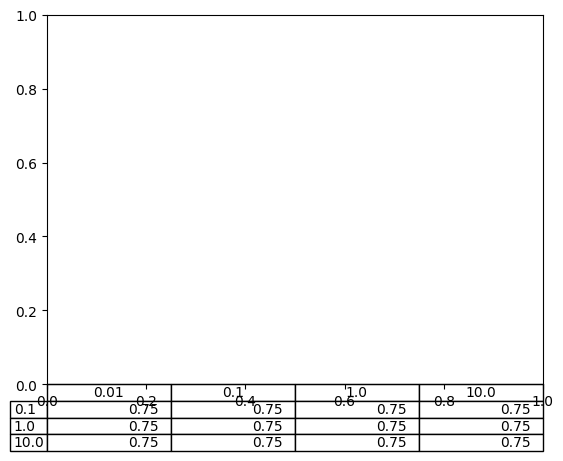

In [14]:
plt.table(cellText=stat_table, rowLabels=grid_C, colLabels=grid_G)

# fig, ax = plt.subplots()
# im, cbar = heatmap(gridsearch, cand_C, cand_gamma, ax=ax, cmap='seismic_r')
# texts = annotate_heatmap(im, valfmt='{x:.2f}', threshold=0.2)
# plt.title('Hyperparameter Gridsearch')
# fig.tight_layout()
# plt.savefig('gridsearch_svc.png', dpi=300, transparent=True)
# plt.clf()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [15]:
best_model = SVC(C=best_parameters['C'], gamma=best_parameters['Gamma'], kernel='rbf')
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'best_model' is not defined